In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Представление и предобработка текстовых данных

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
import torch
from string import punctuation

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

In [ ]:
s = PorterStemmer()
s_words = [s.stem(word) for word in word_tokenize(text)]
s_string = ' '.join(s_words)

l = WordNetLemmatizer()
l_words = [l.lemmatize(word) for word in word_tokenize(text)]
l_string = ' '.join(l_words)

stop_words = set(stopwords.words('english'))
words = [word for word in word_tokenize(text) if word.lower() not in stop_words]
string_sw = ' '.join(words)

translator = str.maketrans('', '', string.punctuation)
string_p = text.translate(translator)

print('Первоначальная строка: ', text)
print()
print('Токенизация: ', word_tokenize(text))
print()
print('Стемминг: ', s_string)
print()
print('Лемматизация: ', s_string)
print()
print('Удаление стоп слов: ', string_sw)
print()
print('Удаление пунктуации: ', string_p)
print()
print('Приведение к нижнему регистру: ', text.lower())

Первоначальная строка:  Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++

Токенизация:  ['Select', 'your', 'preferences', 'and', 'run', 'the', 'install', 'command', '.', 'Stable', 'represents', 'the', 'most', 'currently', 'tested', 'and', 'supported', 'version', 'of', 'PyTorch', '.', 'Note', 'that', 'LibTorch', 'is', 'only', 'available', 'for', 'C++']

Стемминг:  select your prefer and run the instal command . stabl repres the most current test and support version of pytorch . note that libtorch is onli avail for c++

Лемматизация:  select your prefer and run the instal command . stabl repres the most current test and support version of pytorch . note that libtorch is onli avail for c++

Удаление стоп слов:  Select preferences run install command . Stable represents currently tested supported version PyTorch . Note LibTorch available C++

Удаление пунктуации:  

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [ ]:
def preprocess_text(text: str):
  text = text.lower()
  result = re.sub(r'[^a-zA-Z.,!?]', ' ', text)
  return result

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [ ]:
words = set(text.lower().split(' '))
dictionary = {word: index for index, word in enumerate(words)}

first_sentence = nltk.sent_tokenize(text)[0]

sentence_t = torch.zeros(len(dictionary))

for word in words:
  if word in first_sentence:
    sentence_t[dictionary[word]] = 1

print(sentence_t)

{'of', 'c++', 'preferences', 'that', 'command.', 'available', 'install', 'currently', 'your', 'supported', 'for', 'and', 'select', 'the', 'most', 'only', 'represents', 'run', 'tested', 'version', 'stable', 'libtorch', 'is', 'note', 'pytorch.'}
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.])


## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/surnames.csv')
data.head(10)

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
5,Obinata,Japanese
6,Rahal,Arabic
7,Zhuan,Chinese
8,Acconci,Italian
9,Mifsud,Arabic


In [ ]:
label_encoder = LabelEncoder()
data['nationality'] = label_encoder.fit_transform(data['nationality'])
data.head(10)

,surname,nationality
0,Woodford,4
1,Coté,5
2,Kore,4
3,Koury,0
4,Lebzak,14
5,Obinata,10
6,Rahal,0
7,Zhuan,1
8,Acconci,9
9,Mifsud,0


In [ ]:
X = data['surname'].str.lower().str.strip()
y = data['nationality']
n_classes = y.nunique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
class Vocab:
    def __init__(self, data):
        tokens = set()
        for item in data:
            tokens.update(item)

        self.idx_to_token = dict(enumerate(tokens))
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

In [ ]:
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname):
        surname_t = torch.zeros(self.vocab.vocab_len)
        for token in surname:
            surname_t[self.vocab.token_to_idx[token]] = 1
        return surname_t

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), self.y.iloc[idx]

In [ ]:
vocab = Vocab(X)
train_dataset = SurnamesDataset(X_train, y_train, vocab)
test_dataset = SurnamesDataset(X_test, y_test, vocab)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
model = nn.Sequential(nn.Linear(vocab.vocab_len, 512),
        nn.Tanh(),
        nn.Linear(512, n_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
losses_train = []
losses_test = []

In [ ]:
def train_valid(model, epoch, optimizer, train_loader, valid_loader, device, criterion):
  model.train()

  train_losses=[]
  train_list_process=[]

  valid_losses=[]
  valid_list_process=[]

  train_loss = 0
  train_correct = 0

  valid_loss = 0
  valid_correct = 0

  for data, label in train_loader:
    data, label = data.to(device), label.to(device)
    optimizer.zero_grad()
    output = model(data.view(data.size(0), -1))
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    train_correct += pred.eq(label.view_as(pred)).sum().item()

  model.eval()

  with torch.no_grad():
    for data, label in valid_loader:
      data, label = data.to(device), label.to(device)
      output = model(data.view(data.size(0), -1))
      optimizer.zero_grad()
      output = model(data.view(data.size(0), -1))
      valid_loss += criterion(output, label).item()
      pred = output.argmax(dim=1, keepdim=True)
      valid_correct += pred.eq(label.view_as(pred)).sum().item()

  print('epoch for train: {}, accuracy: ({:.2f}%)'.format(epoch+1,train_correct*100 / len(train_loader.dataset)))
  train_list_process.append(train_correct*100 / len(train_loader.dataset))
  losses_train.append(train_loss / len(train_loader))

  print('epoch for valid: {}, accuracy: ({:.2f}%)'.format(epoch+1,valid_correct*100 / len(valid_loader.dataset)))
  print('')
  losses_test.append(valid_loss / len(valid_loader))

In [ ]:
device = 'cpu'

epoch for train: 1, accuracy: (27.29%)
epoch for valid: 1, accuracy: (35.06%)

epoch for train: 2, accuracy: (38.64%)
epoch for valid: 2, accuracy: (39.44%)

epoch for train: 3, accuracy: (41.28%)
epoch for valid: 3, accuracy: (41.21%)

epoch for train: 4, accuracy: (43.39%)
epoch for valid: 4, accuracy: (44.17%)

epoch for train: 5, accuracy: (44.62%)
epoch for valid: 5, accuracy: (44.49%)

epoch for train: 6, accuracy: (46.28%)
epoch for valid: 6, accuracy: (45.86%)

epoch for train: 7, accuracy: (46.84%)
epoch for valid: 7, accuracy: (46.58%)

epoch for train: 8, accuracy: (47.30%)
epoch for valid: 8, accuracy: (47.36%)

epoch for train: 9, accuracy: (47.76%)
epoch for valid: 9, accuracy: (47.91%)

epoch for train: 10, accuracy: (48.14%)
epoch for valid: 10, accuracy: (48.18%)

epoch for train: 11, accuracy: (48.63%)
epoch for valid: 11, accuracy: (48.91%)

epoch for train: 12, accuracy: (49.41%)
epoch for valid: 12, accuracy: (49.36%)

epoch for train: 13, accuracy: (49.52%)
epoch 

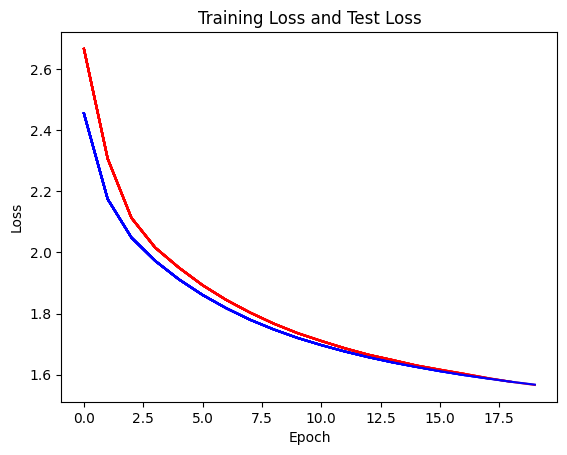

In [ ]:
for epoch in range(20):
  train_valid(model, epoch, optimizer, train_loader, test_loader, device, criterion)

  plt.plot(losses_train, color = 'red', label = 'Train')
  plt.plot(losses_test, color = 'blue', label = 'Test')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss and Test Loss')

In [ ]:
def predict_surname(model, vocab,surname):
    surname_indices = [vocab.token_to_idx[char] for char in surname.lower()]
    surname_tensor = torch.tensor(surname_indices).unsqueeze(0)
    output = model(surname_tensor)
    _, predicted = torch.topk(output, 3)
    predicted_nationalities = label_encoder.inverse_transform(predicted.numpy().flatten())
    print(f'Predicted nationalities for {surname}: {predicted_nationalities}')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred = torch.empty(0)
y_ = torch.empty(0)

for X_batch, y_batch in test_loader:

    predictions = model(X_batch).argmax(dim=1).cpu().detach()
    y_pred = torch.cat((y_pred, predictions))
    y_ = torch.cat((y_, y_batch))

print(classification_report(y_, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83       346
         1.0       0.45      0.53      0.49        36
         2.0       0.32      0.09      0.14        81
         3.0       0.80      0.08      0.15        49
         4.0       0.56      0.76      0.64       567
         5.0       0.00      0.00      0.00        36
         6.0       0.51      0.32      0.40       118
         7.0       0.61      0.34      0.44        32
         8.0       0.78      0.17      0.28        41
         9.0       0.39      0.42      0.41       108
        10.0       0.68      0.53      0.60       161
        11.0       0.33      0.07      0.11        15
        12.0       0.64      0.36      0.46        25
        13.0       0.00      0.00      0.00        14
        14.0       0.73      0.78      0.75       482
        15.0       0.00      0.00      0.00        13
        16.0       0.74      0.25      0.37        57
        17.0       0.00    

In [ ]:
surname = 'Woodford'
x = train_dataset.vectorize(surname.lower()).unsqueeze(0)
_, predictions = model(x).topk(k=3, dim=1)
label_encoder.inverse_transform(predictions.cpu().detach().squeeze())

array(['English', 'German', 'Czech'], dtype=object)

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/raw_train.csv', header=None, names=['Рейтинг', 'Отзыв'])
data = data.sample(frac=0.01, random_state=42)
data.head(5)

,Рейтинг,Отзыв
34566,2,This place is one of my favorite comic shops. ...
223092,1,The wait time for an appointment is ridiculous...
110270,1,I did not like this hotel at all. It's very ol...
365013,2,Mill Avenue has a serious issue with parking. ...
311625,2,Favorite sushi place in NV! Price is reasonab...


In [ ]:
label_encoder = LabelEncoder()
data['Рейтинг'] = label_encoder.fit_transform(data['Рейтинг'])
data['Отзыв'] = data['Отзыв'].apply(preprocess_text)

data

,Рейтинг,Отзыв
34566,1,this place is one of my favorite comic shops. ...
223092,0,the wait time for an appointment is ridiculous...
110270,0,i did not like this hotel at all. it s very ol...
365013,1,mill avenue has a serious issue with parking. ...
311625,1,favorite sushi place in nv! price is reasonab...
...,...,...
108104,0,so..the room was ghetto. the sinks and toilet ...
324165,1,this is always my go to savers. it s the clean...
264865,0,hmmmm...i started out reading other reviews of...
387342,1,i feel like i can t fully review habitat becau...


In [ ]:
X = data['Отзыв']
y = data['Рейтинг']
n_classes = y.nunique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
class Vocab:
    def __init__(self, data):
        tokens = set()
        for sent in data:
            words = [word for word in word_tokenize(sent) if (word not in punctuation)]
            tokens.update(words)
        self.idx_to_token = dict(enumerate(tokens))
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        '''Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)'''
        review_t = torch.zeros(self.vocab.vocab_len)
        words = [word for word in word_tokenize(review) pu(word not in punctuation)]
        for token in words:
            try:
                review_t[self.vocab.token_to_idx[token]] = 1
            except KeyError as ke:
                pass
        return review_t

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X.iloc[idx]), self.y.iloc[idx]

In [ ]:
def train_valid(model, epoch, optimizer, train_loader, valid_loader, device, criterion):
  model.train()

  train_losses=[]
  train_list_process=[]

  valid_losses=[]
  valid_list_process=[]

  train_loss = 0
  train_correct = 0

  valid_loss = 0
  valid_correct = 0

  for data, label in train_loader:
    data, label = data.to(device), label.to(device)
    optimizer.zero_grad()
    output = model(data.view(data.size(0), -1))
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    pred = output.argmax(dim=1, keepdim=True)
    train_correct += pred.eq(label.view_as(pred)).sum().item()

  model.eval()

  with torch.no_grad():
    for data, label in valid_loader:
      data, label = data.to(device), label.to(device)
      output = model(data.view(data.size(0), -1))
      optimizer.zero_grad()
      output = model(data.view(data.size(0), -1))
      valid_loss += criterion(output, label).item()
      pred = output.argmax(dim=1, keepdim=True)
      valid_correct += pred.eq(label.view_as(pred)).sum().item()

  print('epoch for train: {}, accuracy: ({:.2f}%)'.format(epoch+1,train_correct*100 / len(train_loader.dataset)))
  train_list_process.append(train_correct*100 / len(train_loader.dataset))
  losses_train.append(train_loss / len(train_loader))

  print('epoch for test: {}, accuracy: ({:.2f}%)'.format(epoch+1,valid_correct*100 / len(valid_loader.dataset)))
  print('')
  losses_test.append(valid_loss / len(valid_loader))

In [ ]:
vocab = Vocab(X)
train_dataset = ReviewDataset(X_train, y_train, vocab)
test_dataset = ReviewDataset(X_test, y_test, vocab)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
model = nn.Sequential(nn.Linear(vocab.vocab_len, 512),
        nn.ReLU(),
        nn.Linear(512, n_classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
losses_train = []
losses_test = []

epoch for train: 1, accuracy: (82.86%)
epoch for test: 1, accuracy: (90.18%)

epoch for train: 2, accuracy: (97.08%)
epoch for test: 2, accuracy: (90.18%)

epoch for train: 3, accuracy: (99.44%)
epoch for test: 3, accuracy: (89.55%)

epoch for train: 4, accuracy: (99.87%)
epoch for test: 4, accuracy: (89.55%)

epoch for train: 5, accuracy: (99.91%)
epoch for test: 5, accuracy: (89.55%)



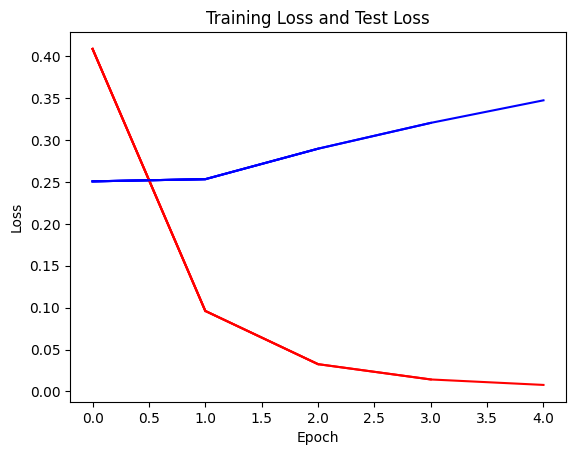

In [ ]:
for epoch in range(5):
  train_valid(model, epoch, optimizer, train_loader, test_loader, device, criterion)

  plt.plot(losses_train, color = 'red', label = 'Train')
  plt.plot(losses_test, color = 'blue', label = 'Test')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss and Test Loss')